In [32]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import scipy as sc
import MH4518.WY.Utils.constants as cs
import MH4518.WY.Utils.Dates as dates 
import MH4518.WY.Utils.payoff as pf
import MH4518.WY.Utils.GBM as gbm
import MH4518.WY.Utils.ProductPrice as pp 
import MH4518.WY.Utils.VarianceRedFunc as vr

import warnings
warnings.filterwarnings("ignore")
import multiprocessing as mp
import logging


%reload_ext autoreload
%autoreload 2


In [5]:

def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()

data

[*********************100%***********************]  2 of 2 completed


Ticker,LONN.SW,SIKA.SW
Date,,
2023-04-27,542.120483,237.429871
2023-04-28,546.263367,242.368103
2023-05-02,545.868896,239.800232
2023-05-03,574.079590,241.479218
2023-05-04,572.895935,242.071823
...,...,...
2024-07-24,522.599976,262.000000
2024-07-25,559.799988,258.500000
2024-07-26,581.000000,262.000000


In [6]:
log_returns_df = pd.DataFrame()
for ticker in cs.ticker_list:
    log_returns = np.log(data[ticker] / data[ticker].shift(1))
    log_returns_df[ticker] = log_returns
log_returns_df.dropna(inplace=True)
log_returns_df
        

,LONN.SW,SIKA.SW
Date,,
2023-04-28,0.007613,0.020585
2023-05-02,-0.000722,-0.010651
2023-05-03,0.050389,0.006977
2023-05-04,-0.002064,0.002451
2023-05-05,-0.000689,0.016188
...,...,...
2024-07-24,0.002299,-0.014776
2024-07-25,0.068763,-0.013449
2024-07-26,0.037171,0.013449


Calibration successful: {'a': np.float64(0.10826990922393587), 'b': np.float64(0.06695567691237256), 'sigma': np.float64(0.008832060537589417)}


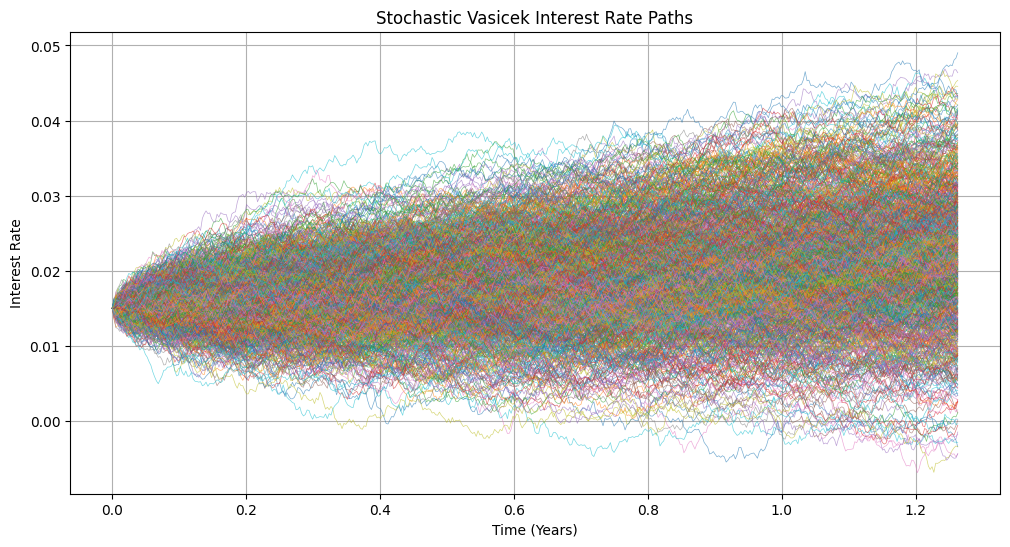

In [16]:
def read_hist_rates():
    swiss_1_week = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 1-Week Bond Yield Historical Data.csv', index_col = 0, parse_dates=True, infer_datetime_format=True)
    swiss_1_month = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 1-Month Bond Yield Historical Data.csv', index_col = 0 , parse_dates=True, infer_datetime_format=True)
    swiss_2_month = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 2-Month Bond Yield Historical Data.csv', index_col = 0 , parse_dates=True, infer_datetime_format=True)
    swiss_6_month = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 6-Month Bond Yield Historical Data.csv', index_col = 0 , parse_dates=True, infer_datetime_format=True)
    swiss_1_year = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 1-Year Bond Yield Historical Data.csv' , index_col = 0 , parse_dates=True, infer_datetime_format=True)
    combined = pd.concat([swiss_1_week[["Price"]], swiss_1_month[["Price"]], swiss_2_month[["Price"]], swiss_6_month[["Price"]], swiss_1_year[["Price"]]], axis = 1)
    combined.columns = ["1 week Price", "1 month Price", "2 month Price", "6 month Price", "1 Year Price"]
   
    return combined

df = read_hist_rates()
maturity_to_years = {
    '1 week Price': 1/52,
    '1 month Price': 1/12,
    '2 month Price': 2/12,
    '6 month Price': 6/12,
    '1 Year Price': 1
}
maturities = df.columns.tolist()
times_to_maturity = np.array([maturity_to_years[m] for m in maturities])

for col in df.columns:
    df[col] = df[col].apply(lambda x: np.exp(-x/100*maturity_to_years[col]))

def vasicek_bond_price(a, b, sigma, r0, T):
    B = (1 - np.exp(-a * T)) / a
    A = (b - (sigma**2) / (2 * a**2)) * (B - T) - (sigma**2) * B**2 / (4 * a)
    P = np.exp(A - B * r0)
    return P

from scipy.optimize import minimize
def calibration_objective(params, bond_maturities, bond_prices, r0):
    a, b, sigma = params
    # Ensure sigma is positive
    if sigma < 0:
        return np.inf
    model_prices = vasicek_bond_price(a, b, sigma, r0, bond_maturities)
    error = bond_prices - model_prices
    return np.sum(error**2)


def calibrate_vasicek(bond_maturities, bond_prices, r0):
    initial_guess = [0.1, 0.05, 0.01]  # [a, b, sigma]
    bounds = [
        (0.01, 1.0),   # a
        (0.01, 0.15),  # b
        (0.001, 0.1)    # sigma
    ]
    
    result = minimize(
        calibration_objective,
        initial_guess,
        args=(bond_maturities, bond_prices, r0),
        method='L-BFGS-B',
        bounds=bounds,
        options={'disp': True}
    )
    
    if result.success:
        calibrated_a, calibrated_b, calibrated_sigma = result.x
        calibrated_params = {
            'a': calibrated_a,
            'b': calibrated_b,
            'sigma': calibrated_sigma
        }
        print(f"Calibration successful: {calibrated_params}")
        return calibrated_params
    else:
        raise ValueError("Calibration failed: " + result.message)
    
calibrated_params = calibrate_vasicek(times_to_maturity, df.loc[cs.initial_fixing_date], 0.015)
def simulate_vasicek(a, b, sigma, r0, T, dt, N_simulations):
    """
    Simulate paths for the stochastic Vasicek interest rate model.
    
    Parameters:
    - a: Speed of mean reversion
    - b: Long-term mean level
    - sigma: Volatility of the interest rate
    - r0: Initial interest rate
    - T: Time horizon (years)
    - dt: Time step size
    - N_simulations: Number of simulation paths
    
    Returns:
    - time_grid: Array of time points
    - r_paths: Simulated interest rate paths (N_simulations x N_steps)
    """
    N_steps = int(T / dt)
    time_grid = np.linspace(0, T, N_steps)
    r_paths = np.zeros((N_simulations, N_steps))
    r_paths[:, 0] = r0
    
    dates = pd.date_range(cs.initial_fixing_date, cs.final_fixing_date)
    for t in range(1, N_steps):
        dr = a * (b - r_paths[:, t-1]) * dt + sigma * np.sqrt(dt) * np.random.randn(N_simulations)
        r_paths[:, t] = r_paths[:, t-1] + dr
    
    return time_grid, r_paths
a_calibrated = calibrated_params['a']
b_calibrated = calibrated_params['b']
sigma_r_calibrated = calibrated_params['sigma']

time_grid, r_paths = simulate_vasicek(a_calibrated, b_calibrated, sigma_r_calibrated, 0.015, (461/365), 1/365, 1000)


def plot_vasicek_matplotlib(time_grid, r_paths, num_paths=1000):
    """
    Plot a subset of Vasicek interest rate paths using Matplotlib.
    
    Parameters:
    - time_grid: Array of time points
    - r_paths: Simulated interest rate paths (N_simulations x N_steps)
    - num_paths: Number of paths to plot
    """
    plt.figure(figsize=(12, 6))
    
    # Randomly select paths to plot
    selected_indices = np.random.choice(r_paths.shape[0], size=num_paths, replace=False)
    
    for idx in selected_indices:
        plt.plot(time_grid, r_paths[idx], lw=0.5, alpha=0.6)
    
    plt.title('Stochastic Vasicek Interest Rate Paths')
    plt.xlabel('Time (Years)')
    plt.ylabel('Interest Rate')
    plt.grid(True)
    plt.show()

#Plot Vasicek Interest Rate Paths
plot_vasicek_matplotlib(time_grid, r_paths, num_paths=1000)

In [40]:
import pandas_market_calendars as cal 
def add_h_business_days(date: pd.Timestamp, h:int):
    '''
    Adds h number of days to a specified date. 
    '''
    six_cal = cal.get_calendar('SIX')
    valid_days = six_cal.valid_days(start_date=date, end_date=date + pd.Timedelta(days=h*2))
    
 
    if len(valid_days) < h:
        raise ValueError("Not enough trading days in the given range.")
    

    return valid_days[h - 1].tz_localize(None)

add_h_business_days(cs.initial_fixing_date, 10)

Timestamp('2023-05-11 00:00:00')

In [43]:
from scipy.stats import t
from scipy import stats
def student_t_fit_params(asset, logreturns):
    '''
    Returns the Parameters for fitting of data in to student t distribution 

    '''
    log_returns_asset_df = logreturns[asset]
    dof_lonn, loc_lonn, scale_lonn = t.fit(log_returns_asset_df)
    return dof_lonn, loc_lonn, scale_lonn 
    


    
    

In [44]:
from scipy.stats import t, multivariate_normal

def generate_correlated_t_random_variables(df, corr_matrix, size):
    """
    Generates correlated t-distributed random variables.
    
    Params:
        df: Degrees of freedom
        corr_matrix: Correlation matrix
        size: Tuple indicating the size (num_steps - 1, nsims, num_assets)
        
    Returns:
        correlated_t_rvs: Array of correlated t-distributed random variables
    """
    num_assets = corr_matrix.shape[0]
    num_steps = size[0]
    nsims = size[1]
    
    # Cholesky decomposition of the correlation matrix
    L = np.linalg.cholesky(corr_matrix)
    
    # Generate standard normal random variables
    Z = np.random.standard_normal((num_steps, nsims, num_assets))
    
    # Generate chi-squared random variables
    chi2 = np.random.chisquare(df, (num_steps, nsims))  # Shape: (num_steps, nsims)
    chi2 = chi2[:, :, np.newaxis]  # Shape: (num_steps, nsims, 1)
    
    # Generate t-distributed random variables
    T = Z / np.sqrt(chi2 / df)
    
    # Introduce correlation
    T_correlated = np.einsum('ijk,kl->ijl', T, L.T)
    
    return T_correlated  # Shape: (num_steps, nsims, num_assets)


In [50]:
def sim_asset_t_dist(fdos, nsims, data):
    '''
    Simulates asset paths using fitted t-distributions and maintains correlation.
    
    Params:
        fdos: Specified first day of simulation 
        nsims: Number of simulations to be carried out
        data: Historical price data with columns for each asset
        
    Returns:
        lonza_paths: Simulated price paths for Lonza
        sika_paths: Simulated price paths for Sika
        date_list: List of simulation dates
    '''
    # Prepare the log returns DataFrame
    log_returns_df = pd.DataFrame()
    for ticker in cs.ticker_list:
        log_returns = np.log(data[ticker] / data[ticker].shift(1))
        log_returns_df[ticker] = log_returns
    log_returns_df.dropna(inplace=True)
    
    # Compute the covariance and correlation matrices
    cov_matrix = log_returns_df.cov().values
    vol_vector = np.sqrt(np.diag(cov_matrix))
    corr_matrix = cov_matrix / np.outer(vol_vector, vol_vector)
    
    # Simulation parameters
    var_end_date = add_h_business_days(fdos, 10)
    date_list = dates.get_list_dates(fdos, var_end_date)
    num_steps = len(date_list)
    dt = cs.dt  # Time step in years
    
    num_assets = cs.num_ticker
    s0_vector = data.loc[fdos, cs.ticker_list].values  # Initial prices
    
    # Fit t-distribution parameters
    params_lonza = student_t_fit_params(asset='LONN.SW', logreturns=log_returns_df)
    params_sika = student_t_fit_params(asset='SIKA.SW', logreturns=log_returns_df)
    
    # Use a common degrees of freedom for multivariate t-distribution
    df_common = min(params_lonza[0], params_sika[0])
    
    size = (num_steps - 1, nsims)
    T_correlated = generate_correlated_t_random_variables(df_common, corr_matrix, size)
    
    
    # Extract random variables and adjust for location and scale
    lonza_Z = params_lonza[1] + params_lonza[2] * T_correlated[:, :, 0]
    sika_Z = params_sika[1] + params_sika[2] * T_correlated[:, :, 1]
    
    # Initialize asset paths
    lonza_paths = np.zeros((num_steps, nsims))
    sika_paths = np.zeros((num_steps, nsims))
    lonza_paths[0, :] = s0_vector[0]
    sika_paths[0, :] = s0_vector[1]
    
    # Compute drifts
    r = cs.interest_rate  # Risk-free rate
    drift_lonza = (r - 0.5 * vol_vector[0] ** 2) * dt
    drift_sika = (r - 0.5 * vol_vector[1] ** 2) * dt
    
    # Simulation loop with dividend adjustments
    for t in range(1, num_steps):
        # Update Lonza prices
        lonza_paths[t] = lonza_paths[t - 1] * np.exp(
            drift_lonza + vol_vector[0] * lonza_Z[t - 1]
        )
        
    
    return lonza_paths, sika_paths, date_list


In [53]:
lonza_paths, sika_paths, date_list = sim_asset_t_dist(fdos = cs.initial_fixing_date, nsims = 1000, data = data )

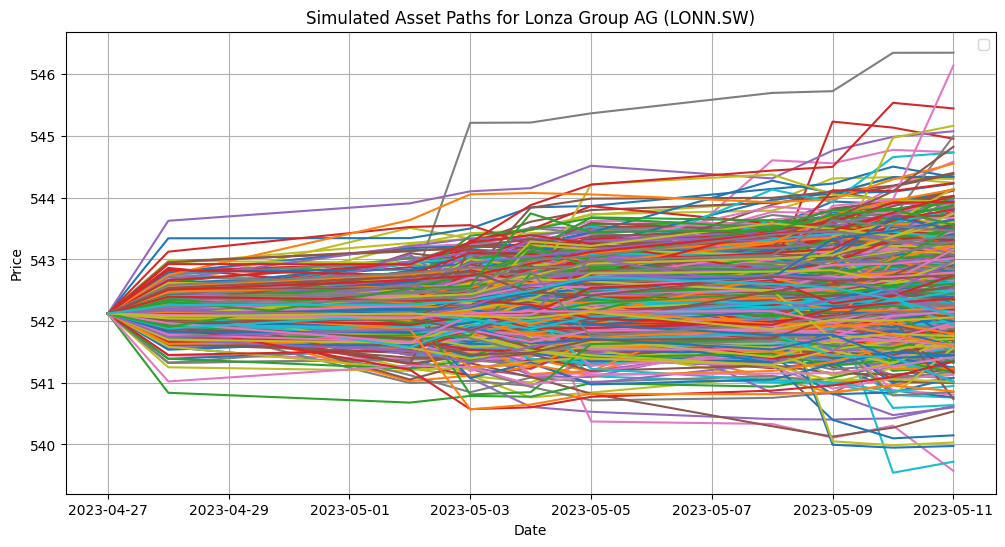

In [57]:
import matplotlib.pyplot as plt

# Select a subset of simulations to plot (e.g., first 10)
num_plots = 1000
plt.figure(figsize=(12, 6))
for i in range(num_plots):
    plt.plot(date_list, lonza_paths[:, i])
plt.title('Simulated Asset Paths for Lonza Group AG (LONN.SW)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
